<a href="https://colab.research.google.com/github/seoes/odyssey-ai/blob/seo/supervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 설정

## 첫 설정

In [1]:
import torch
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## YOLOv5 설치 후 모델 불러오기

In [2]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Cloning into 'yolov5'...
remote: Enumerating objects: 16008, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 16008 (delta 22), reused 21 (delta 13), pack-reused 15967
Receiving objects: 100% (16008/16008), 14.60 MiB | 22.68 MiB/s, done.
Resolving deltas: 100% (10988/10988), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-10-19 Python-3.10.12 torch-2.0.1+cu118 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 113MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## Supervision 설치

In [12]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv

## 샘플 mp4 영상 다운로드 후 경로 설정

In [4]:
import os
HOME = os.getcwd()
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr" -O market-square.mp4 && rm -rf /tmp/cookies.txt

SAMPLE_VIDEO_PATH = f"{HOME}/market-square.mp4"
SAMPLE_IMAGE_PATH = f"{HOME}/sample_photo.png"

/content/yolov5
--2023-10-19 01:05:41--  https://docs.google.com/uc?export=download&confirm=&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr
Resolving docs.google.com (docs.google.com)... 173.194.212.100, 173.194.212.102, 173.194.212.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.212.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d162t679koo7fv6rifajed7o8ek6sidr/1697677500000/04309230031174164349/*/1vVrEVMxucHgqGd7vAa501ASojbeGPhIr?e=download&uuid=ba227d4b-f2dc-4a49-9e65-5acb1c4d65bc [following]
--2023-10-19 01:05:42--  https://doc-0k-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d162t679koo7fv6rifajed7o8ek6sidr/1697677500000/04309230031174164349/*/1vVrEVMxucHgqGd7vAa501ASojbeGPhIr?e=download&uuid=ba227d4b-f2dc-4a49-9e65-5acb1c4d65bc
Resolving doc-0k-ag-docs.googleusercontent.com (doc-0k-ag-docs.googleusercontent.com).

# 영상 분석

## 준비

In [5]:
# 색 설정
colors = sv.ColorPalette.default()

# 비디오 파일 정보 추출
video_info = sv.VideoInfo.from_video_path(SAMPLE_VIDEO_PATH)

## Polygon 형태로 구역 나누기

In [6]:
# numpy의 배열 형식으로 다각형의 폴리곤 형태 정의
polygons = [
    np.array([
        [540,  985 ],
        [1620, 985 ],
        [2160, 1920],
        [1620, 2855],
        [540,  2855],
        [0,    1920]
    ], np.int32),
    np.array([
        [0,    1920],
        [540,  985 ],
        [0,    0   ]
    ], np.int32),
    np.array([
        [1620, 985 ],
        [2160, 1920],
        [2160,    0]
    ], np.int32),
    np.array([
        [540,  985 ],
        [0,    0   ],
        [2160, 0   ],
        [1620, 985 ]
    ], np.int32),
    np.array([
        [0,    1920],
        [0,    3840],
        [540,  2855]
    ], np.int32),
    np.array([
        [2160, 1920],
        [1620, 2855],
        [2160, 3840]
    ], np.int32),
    np.array([
        [1620, 2855],
        [540,  2855],
        [0,    3840],
        [2160, 3840]
    ], np.int32)
]



zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=6,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]

## 인식

In [13]:
# 비디오에서 프레임 추출
generatedFrames = sv.get_video_frames_generator(SAMPLE_VIDEO_PATH) # 프레임 추출
iterator = iter(generatedFrames) # 추출된 프레임들을 반복자로 변환
frame = next(iterator) # 반복자의 다음 항목 가져오기

# 이미지 불러오기
# image = cv2.imread(SAMPLE_IMAGE_PATH)
# frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# 각 zone에 대한 체류 시간을 저장하는 2차원 배열 초기화
zone_durations = [[] for _ in range(len(polygons))]


def process_frame(frame: np.ndarray, i) -> np.ndarray:
    print(i)
    # detect
    results = model(frame, size=1280)
    detections = sv.Detections.from_yolov5(results)
    detections = detections[(detections.class_id == 0)]

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)

        # 현재 프레임에서 해당 zone에서 감지된 사람의 수를 배열에 추가
        zone_durations[idx].append(len(detections_filtered))


    return frame

for idx, durations in enumerate(zone_durations):
    print(f"Zone {idx + 1} total duration: {sum(durations)} frames")


# mp4 파일로 출력

# sv.process_video(source_path=SAMPLE_VIDEO_PATH, target_path=f"{HOME}/market-square-result.mp4", callback=process_frame)


# 첫 프레임만 출력



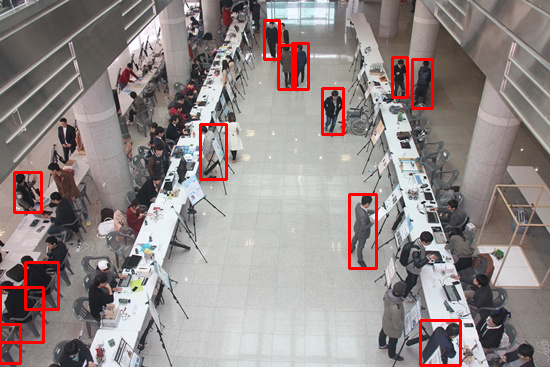

In [ ]:
from google.colab.patches import cv2_imshow

# 이미지 불러오기
image = cv2.imread(SAMPLE_IMAGE_PATH)

results = model(image)
person_boxes = results.pandas().xyxy[0]

for box in person_boxes.values:
  x1, y1, x2, y2, _, _, _ = box
  cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
cv2_imshow(image)